# Generate a mock Damped Harmonic Oscillaotry CARMA (2,1) lightcurve and fit it with Kali

Tutorial by Jackeline Moreno
Date April 10, 2019

Use the python3 updated Kali-fork by Wexiang Yu, Drexel University https://github.com/ywx649999311/kali
***this code has not been tested with the master branch of Kali**

In [1]:
import numpy as np
import kali.carma 
import simpleLC #file available in repo
import corner

In [2]:
# tutorial from the paper



#------------Simulate a CARMA lightcurve-------------------------------------

# Declare characteristic timescales in units of days
decay = 100.
qpo = 65.
blue = 40.
# define a scaling factor for the amplitude of variability
amp = 1.0 

#Set up roots using the input timescales
roots = np.array([complex(-1.0/decay, (1.)/qpo), complex(-1.0/decay, -(1.)/qpo), -1.0/blue, amp])

#Compute CARMA differential equation parameters from the roots 
p, q = 2, 1
DHO_theta = kali.carma.coeffs(p, q, roots)

#initialize a Kali CARMA(p, q) object
DHO_model = kali.carma.CARMATask(p, q)

#pass the CARMA parameters and sampling rate to the Kali object
samplingRate = 1.0 # Cadence of the observations in days
DHO_model.set(samplingRate,DHO_theta)

#simulate a ten-year lightcurve
#Specifying a seed to enable repeatability of the experiment
DHO_lc = DHO_model.simulate(duration=365.0*10., distSeed=384872)

#add measurement noise to the simulated lightcurve
DHO_model.fracNoiseToSignal = 0.10 # (10\% relative to arbitrary units)
DHO_model.observe(DHO_lc)



/home/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: ComplexWarning: Casting complex values to real discards the imaginary part


Timescale prediction using max-likelihood
67.49495376245 106.05553729488729 44.14832008794314


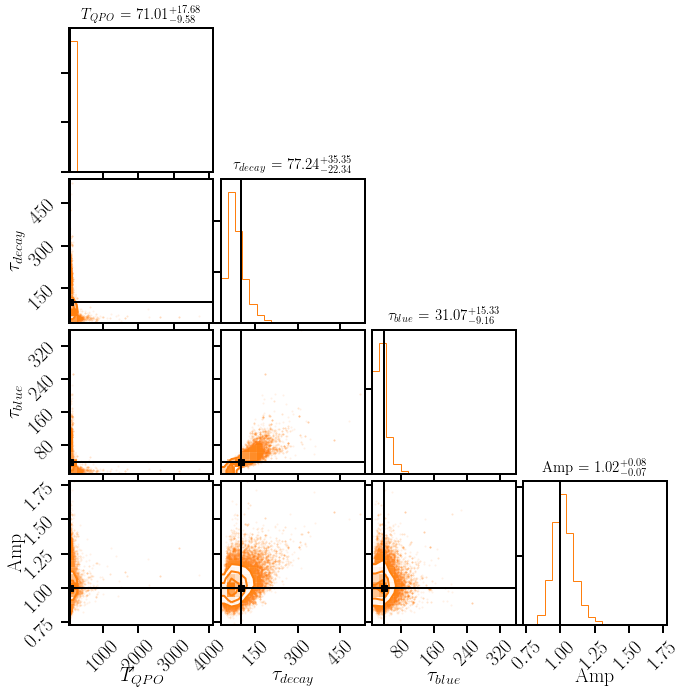

In [3]:
#initialize a Kali lightcurve object
simLC = simpleLC.declareLC(x=DHO_lc.t, y=DHO_lc.y, yerr=DHO_lc.yerr)

#Initialize a Kali time series analysis object
#Also pass MCMC parameters to CARMATask
fitTask = kali.carma.CARMATask(2, 1, nthreads = 4, nburn = 100000, nsteps = 2000)
#infer CAMRA parameters
fitTask.fit(simLC)


#Extract each individual CARMA parameter
alpha1 = fitTask.Chain[0,:,500:].flatten()
alpha2 = fitTask.Chain[1,:,500:].flatten()
beta0 = fitTask.Chain[2,:,500:].flatten()
beta1 = fitTask.Chain[3,:,500:].flatten()

#Extract the amplitude from rootChain  
amplitude = fitTask.rootChain[-1,:,500:].flatten()

#Create array to hold timescales that is properly shaped for making "corner" plots
timescales = np.zeros(shape = (len(alpha1), 4))
flag = np.zeros(len(alpha1)) 

for i in range(0, len(alpha1)):
    roots = np.roots([1.,alpha1[i], alpha2[i]])
    #if MCMC samples explore the DHO parameter space with two real roots
    #rather than complex conjugate roots, set flag to zero
    if roots[0].imag == 0:
        #rise timescale
        timescales[i, 0] = 1./abs(roots[0].real)
        flag[i] = 0
    else: 
        #T_qpo
        timescales[i, 0] = 1./abs(roots[0].imag)
        flag[i] = 1
    #decay timescale    
    timescales[i, 1] = 1./abs(roots[1].real)
    #perturbation timescale
    timescales[i,2] = beta1[i]/beta0[i]
    #amplitude of variability
    timescales[i,3] = amplitude[i]
    
#plot timescales from MCMC posterior sampling   
corner.corner(timescales[flag == 1,:], truths = [qpo, decay, blue, amp],
              truth_color='black',labels=[r'$T_{QPO}$', r'$\tau_{decay}$', r'$\tau_{blue}$', 'Amp'],
              color = 'C1', show_titles = True,title_kwargs={"fontsize":15})              
print("Timescale prediction using max-likelihood")
bestTheta = fitTask.bestTheta
rootsBest = np.roots([1,bestTheta[0], bestTheta[1]])
#print maximum likelihood timescales
print(1./abs(rootsBest[0].imag),1./abs(rootsBest[1].real),bestTheta[-1]/bestTheta[-2])    



